In [1]:
from usl_models.flood_ml.dataset import download_dataset, load_dataset_cached, load_dataset_windowed_cached

import tensorflow as tf
import keras_tuner
import time
import keras
import logging
from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml.model_params import FloodModelParams
from usl_models.flood_ml.dataset import load_dataset_windowed, load_dataset
import pathlib
# === CONFIG ===
# Set random seeds and GPU memory growth
logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

timestamp = time.strftime("%Y%m%d-%H%M%S")
log_dir = f"logs/training_{timestamp}"

2025-10-08 20:43:55.517048: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 20:43:55.575147: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-08 20:43:55.575198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-08 20:43:55.577307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-08 20:43:55.587276: I tensorflow/core/platform/cpu_feature_guar

In [8]:
# Prediction mode
from usl_models.flood_ml import dataset
import pathlib

# Parameters
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
# prediction
sim_name = ["Atlanta_Prediction"]
rainfall_sim = "Atlanta-Atlanta_config/Rainfall_Data_22.txt"



# Download (prediction mode)
# dataset.download_dataset(
#     sim_names=sim_name,          # study area
#     output_path=filecache_dir,
#     include_labels=False,                      # no labels
#     rainfall_sim_name=rainfall_sim,  # simulation for temporal vector
#     allow_missing_sim=True                     # skip temporal if missing
# )
# prediction mode
# # # Load dataset
full_dataset = dataset.load_dataset_cached(
    filecache_dir=filecache_dir,
    sim_names=sim_name,            # study area
    dataset_split=None,                          # no split for prediction
    batch_size=2,
    include_labels=False,
    shuffle=False,
    rainfall_sim_name=rainfall_sim  # actual rainfall sim
)


# Download (training mode)
# dataset_splits = ["test", "train", "val"]
# dataset.download_dataset(
#     sim_names=["Atlanta-Atlanta_config/Rainfall_Data_22.txt"],  # normal simulations
#     output_path=filecache_dir,
#     dataset_splits=dataset_splits,               # train/val/test splits
#     include_labels=True                        # get labels too
# )

full_dataset = dataset.load_dataset_cached(
    filecache_dir=filecache_dir,
    sim_names=["Manhattan-Manhattan_config/Rainfall_Data_22.txt"],
    dataset_split="train",
    batch_size=2,
    include_labels=True
)


In [9]:
import tensorflow as tf
from usl_models.flood_ml.model import FloodModel, SpatialAttention
# Path to your saved model
model_path = "/home/se2890/climateiq-cnn-9/logs/htune_project_20251008-204114/model"
loaded_model = tf.keras.models.load_model(model_path)
loaded_model.summary()
# Load the model
model = tf.keras.models.load_model(model_path)
# model = FloodModel.from_checkpoint(model_path)

from usl_models.flood_ml.model import SpatialAttention
custom_objects = {'SpatialAttention': SpatialAttention}
loaded_model = tf.keras.models.load_model(
    model_path,
    custom_objects=custom_objects,
    compile=False
)
model.set_weights(loaded_model.get_weights())

# # Test calling the model for n predictions
# full_dataset = load_dataset(sim_names=sim_names, batch_size=4, dataset_split= "train")
inputs, labels,  name = next(iter(full_dataset))
predictions = model.call_n(inputs, n=2)
predictions.shape

Model: "flood_conv_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatiotemporal_cnn (Sequen  (None, None, 250, 250,    3424      
 tial)                       16)                                 
                                                                 
 geospatial_cnn (Sequential  (None, 250, 250, 64)      29280     
 )                                                               
                                                                 
 spatial_attention_6 (Spati  multiple                  99        
 alAttention)                                                    
                                                                 
 conv_lstm (Sequential)      (None, 250, 250, 64)      345856    
                                                                 
 spatial_attention_7 (Spati  multiple                  99        
 alAttention)                                    

TensorShape([2, 2, 1000, 1000])

In [10]:
import tensorflow as tf
import numpy as np

BATCH_SIZE = 2
N_STEPS = 2

all_max_preds_np = []    # list of [B, H, W] NumPy arrays
all_max_labels_np = []   # only filled if true labels exist
all_chunk_names = []

for i, (inputs, labels, metadata) in enumerate(full_dataset):
    current_bs = inputs["spatiotemporal"].shape[0]
    chunk_names = metadata["feature_chunk"].numpy().astype(str).tolist()
    all_chunk_names.extend(chunk_names)

    print(f"\n[Batch {i}] Chunk names: {chunk_names}")

    # --- Handle incomplete batches ---
    if current_bs < BATCH_SIZE:
        repeats = BATCH_SIZE - current_bs

        def pad_tensor(t):
            return tf.concat([t, tf.repeat(t[-1:], repeats=repeats, axis=0)], axis=0)

        padded_inputs = {k: pad_tensor(v) for k, v in inputs.items()}
        preds = model.call_n(padded_inputs, n=N_STEPS)[:current_bs]
    else:
        preds = model.call_n(inputs, n=N_STEPS)

    print(f"[Batch {i}] Prediction shape: {preds.shape}")

    # --- Convert predictions immediately to NumPy (CPU-safe) ---
    preds_np = preds.numpy()
    max_pred_np = np.max(preds_np, axis=1)   # [B, H, W]
    all_max_preds_np.append(max_pred_np)

    # --- Only store real labels (skip dummy zeros in prediction mode) ---
    if tf.reduce_sum(tf.cast(labels != 0.0, tf.int32)) > 0:
        labels_np = labels.numpy()
        max_label_np = np.max(labels_np, axis=1)
        all_max_labels_np.append(max_label_np)

# --- Final NumPy arrays on CPU ---
max_preds_all_np = np.concatenate(all_max_preds_np, axis=0)            # [N, H, W]
max_labels_all_np = (
    np.concatenate(all_max_labels_np, axis=0) if all_max_labels_np else None
)

print("\n✅ Aggregation complete:")
print(f"  - Chunks: {len(all_chunk_names)}")
print(f"  - max_preds_all_np: {max_preds_all_np.shape}")
print(f"  - max_labels_all_np: {'None' if max_labels_all_np is None else max_labels_all_np.shape}")



[Batch 0] Chunk names: ['5_5', '4_2']
[Batch 0] Prediction shape: (2, 2, 1000, 1000)

[Batch 1] Chunk names: ['4_4', '1_10']
[Batch 1] Prediction shape: (2, 2, 1000, 1000)

[Batch 2] Chunk names: ['4_5', '4_1']
[Batch 2] Prediction shape: (2, 2, 1000, 1000)

[Batch 3] Chunk names: ['3_5', '2_8']
[Batch 3] Prediction shape: (2, 2, 1000, 1000)

[Batch 4] Chunk names: ['1_8', '5_1']
[Batch 4] Prediction shape: (2, 2, 1000, 1000)

[Batch 5] Chunk names: ['2_9', '4_6']
[Batch 5] Prediction shape: (2, 2, 1000, 1000)

[Batch 6] Chunk names: ['5_4', '3_4']
[Batch 6] Prediction shape: (2, 2, 1000, 1000)

[Batch 7] Chunk names: ['4_3', '2_7']
[Batch 7] Prediction shape: (2, 2, 1000, 1000)

✅ Aggregation complete:
  - Chunks: 16
  - max_preds_all_np: (16, 1000, 1000)
  - max_labels_all_np: (16, 1000, 1000)


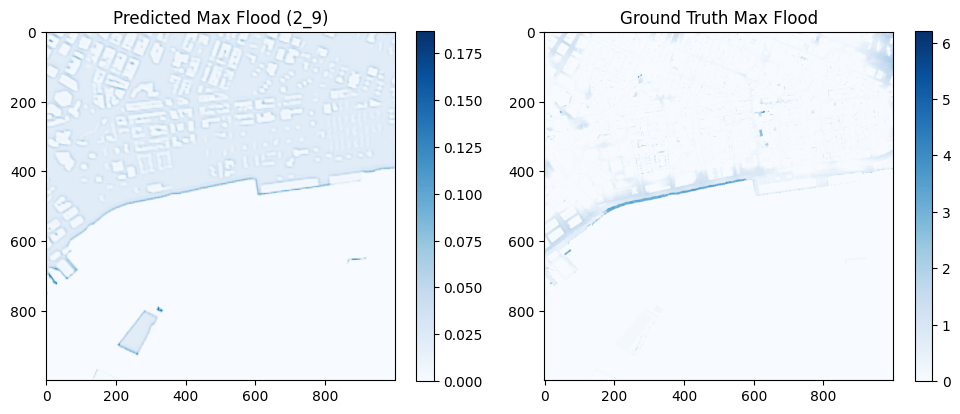

In [11]:
import matplotlib.pyplot as plt

i = min(10, len(all_chunk_names) - 1)  # safe index

plt.figure(figsize=(10, 4))

# --- Prediction map ---
plt.subplot(1, 2, 1)
plt.imshow(max_preds_all_np[i], cmap="Blues")
plt.title(f"Predicted Max Flood ({all_chunk_names[i]})")
plt.colorbar()

# --- Ground truth or “no labels” notice ---
plt.subplot(1, 2, 2)
if max_labels_all_np is not None:
    plt.imshow(max_labels_all_np[i], cmap="Blues")
    plt.title("Ground Truth Max Flood")
    plt.colorbar()
else:
    plt.axis("off")
    plt.text(
        0.5, 0.5,
        "No Ground Truth Available\n(Prediction Mode)",
        ha="center", va="center",
        fontsize=12,
        color="gray",
    )

plt.tight_layout()
plt.show()


/var/tmp/ipykernel_136214/1903554270.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.97])


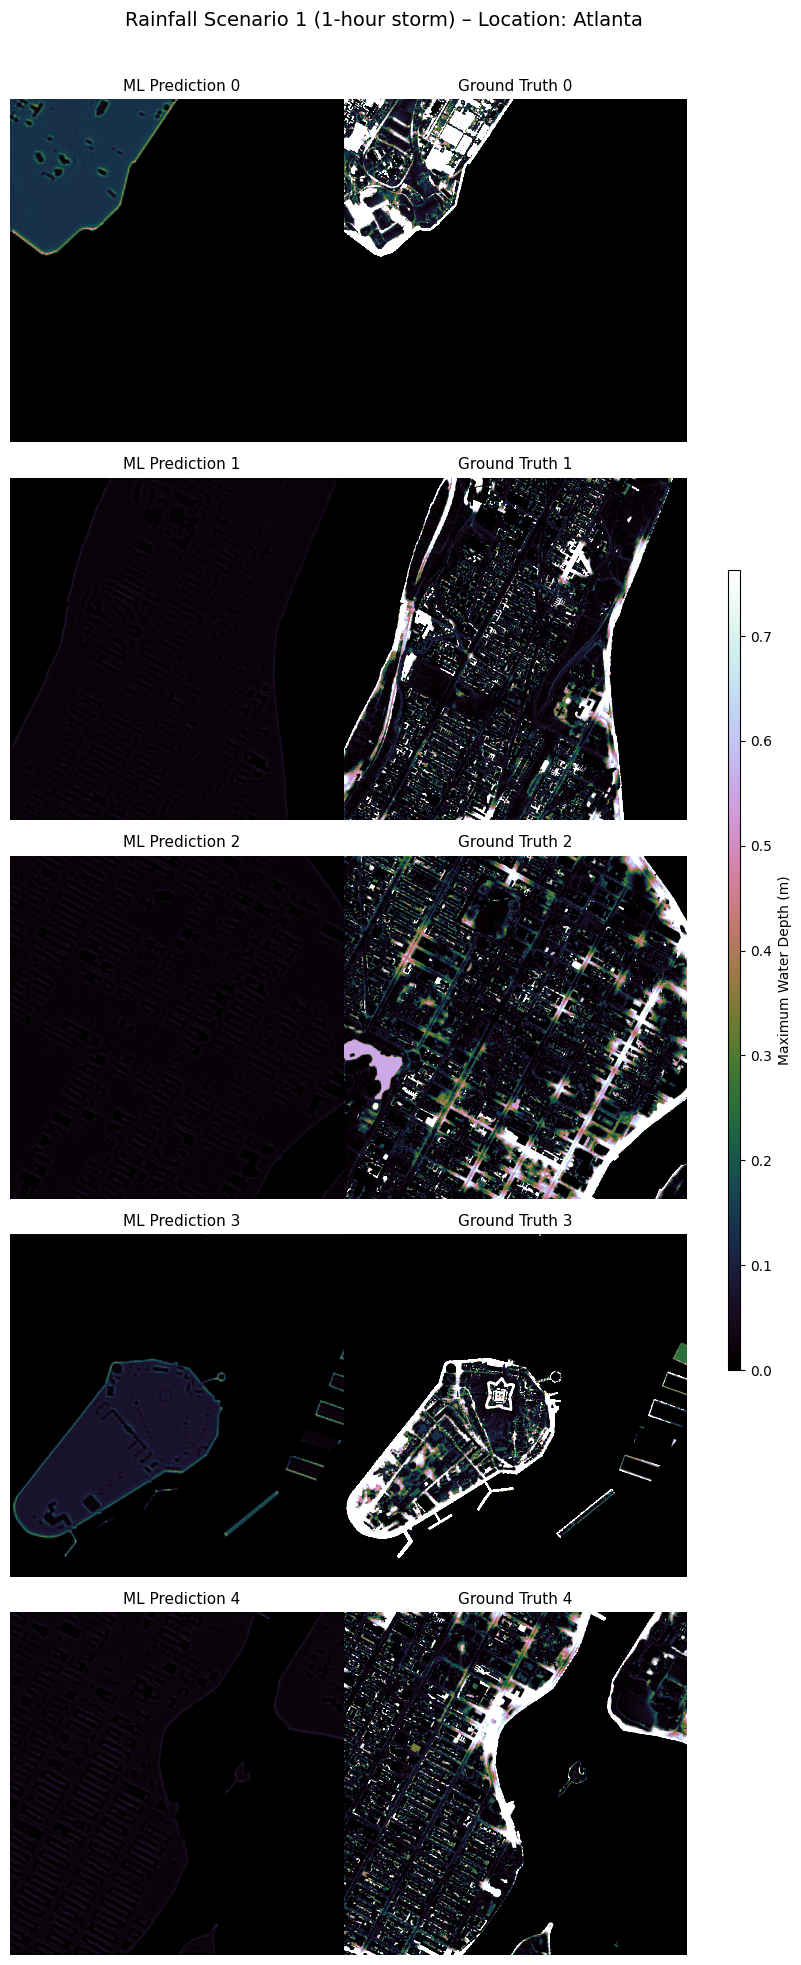

In [12]:
import matplotlib.pyplot as plt
import numpy as np

num_to_plot = min(5, len(max_preds_all_np))  # limit to available samples
has_labels = max_labels_all_np is not None   # prediction vs training mode

# --- Layout ---
ncols = 2 if has_labels else 1
fig, axes = plt.subplots(
    num_to_plot,
    ncols,
    figsize=(8 if has_labels else 4, num_to_plot * 4),
    squeeze=False,  # always 2D array of axes
)

fig.subplots_adjust(wspace=0.05, hspace=0.25)

for i in range(num_to_plot):
    pred = max_preds_all_np[i]

    # Dynamic color scaling (robust to outliers)
    if has_labels:
        truth = max_labels_all_np[i]
        combined = np.concatenate([pred.flatten(), truth.flatten()])
        vmin = np.percentile(combined, 2)
        vmax = np.percentile(combined, 98)
    else:
        vmin = np.percentile(pred, 2)
        vmax = np.percentile(pred, 98)

    # --- Prediction map ---
    ax_pred = axes[i, 0]
    im_pred = ax_pred.imshow(pred, cmap="cubehelix", vmin=vmin, vmax=vmax)
    ax_pred.set_title(f"ML Prediction {i}", fontsize=11)
    ax_pred.axis("off")

    # --- Ground truth / placeholder ---
    if has_labels:
        ax_truth = axes[i, 1]
        ax_truth.imshow(truth, cmap="cubehelix", vmin=vmin, vmax=vmax)
        ax_truth.set_title(f"Ground Truth {i}", fontsize=11)
        ax_truth.axis("off")
    else:
        # Add placeholder notice next to the prediction
        ax_note = ax_pred.twinx()  # overlay note to the right of the image
        ax_note.axis("off")
        ax_note.text(
            1.05, 0.5,
            "No Ground Truth\nAvailable",
            transform=ax_pred.transAxes,
            ha="left",
            va="center",
            fontsize=11,
            color="gray",
        )

# --- Shared colorbar ---
cbar_ax = fig.add_axes([0.93, 0.3, 0.015, 0.4])
fig.colorbar(im_pred, cax=cbar_ax, label="Maximum Water Depth (m)")

plt.suptitle(
    "Rainfall Scenario 1 (1-hour storm) – Location: Atlanta",
    fontsize=14,
    y=0.98,
)
plt.tight_layout(rect=[0, 0, 0.91, 0.97])
plt.show()


In [9]:
# pip install rasterio

In [13]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from google.cloud import storage
import tempfile
import os

# === Geo metadata ===
pixel_size = 1
top_left_x = 0
top_left_y = 0
transform = from_origin(top_left_x, top_left_y, pixel_size, pixel_size)
crs = "EPSG:4326"

# === GCS setup ===
client = storage.Client()
bucket_name = "mloutputstest"
bucket = client.bucket(bucket_name)

# === Notebook inputs ===
sim_name = ["Atlanta_test_Prediction"]
rainfall_sim = "Atlanta_test_Prediction/Rainfall_Data_22.txt"

rainfall_scenario = rainfall_sim.split("/")[-1]  # e.g. "Rainfall_Data_22.txt"
study_area = sim_name[0]                         # e.g. "Manhattan-Manhattan_config_Prediction"

# === Define GCS folder structure ===
base_folder = f"{study_area}/scenario_{rainfall_scenario}"
tif_folder = f"{base_folder}/tif"
png_folder = f"{base_folder}/png"

# === Final arrays on CPU ===
N = max_preds_all_np.shape[0]
has_labels = max_labels_all_np is not None

print(f"\nSaving {N} predicted chunks to gs://{bucket_name}/{base_folder}")
print(f"Ground-truth labels detected: {has_labels} (will NOT be uploaded)")

for idx in range(N):
    chunk_name = all_chunk_names[idx] if idx < len(all_chunk_names) else f"chunk_{idx}"
    sample = max_preds_all_np[idx]  # Already NumPy on CPU

    # --- Save GeoTIFF (prediction only) ---
    with tempfile.NamedTemporaryFile(suffix=".tif") as tmp_tif:
        with rasterio.open(
            tmp_tif.name,
            "w",
            driver="GTiff",
            height=sample.shape[0],
            width=sample.shape[1],
            count=1,
            dtype=sample.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(sample, 1)

        tif_blob_path = f"{tif_folder}/{chunk_name}.tif"
        bucket.blob(tif_blob_path).upload_from_filename(tmp_tif.name)
        print(f"✅ Uploaded GeoTIFF: gs://{bucket_name}/{tif_blob_path}")

    # --- Save PNG (prediction only) ---
    with tempfile.NamedTemporaryFile(suffix=".png") as tmp_png:
        plt.imsave(tmp_png.name, sample, cmap="Blues")
        png_blob_path = f"{png_folder}/{chunk_name}.png"
        bucket.blob(png_blob_path).upload_from_filename(tmp_png.name)
        print(f"✅ Uploaded PNG: gs://{bucket_name}/{png_blob_path}")

print("\n✅ All prediction files uploaded successfully.")



Saving 16 predicted chunks to gs://mloutputstest/Atlanta_test_Prediction/scenario_Rainfall_Data_22.txt
Ground-truth labels detected: True (will NOT be uploaded)


/home/se2890/.local/lib/python3.11/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


✅ Uploaded GeoTIFF: gs://mloutputstest/Atlanta_test_Prediction/scenario_Rainfall_Data_22.txt/tif/5_5.tif
✅ Uploaded PNG: gs://mloutputstest/Atlanta_test_Prediction/scenario_Rainfall_Data_22.txt/png/5_5.png
✅ Uploaded GeoTIFF: gs://mloutputstest/Atlanta_test_Prediction/scenario_Rainfall_Data_22.txt/tif/4_2.tif
✅ Uploaded PNG: gs://mloutputstest/Atlanta_test_Prediction/scenario_Rainfall_Data_22.txt/png/4_2.png
✅ Uploaded GeoTIFF: gs://mloutputstest/Atlanta_test_Prediction/scenario_Rainfall_Data_22.txt/tif/4_4.tif
✅ Uploaded PNG: gs://mloutputstest/Atlanta_test_Prediction/scenario_Rainfall_Data_22.txt/png/4_4.png
✅ Uploaded GeoTIFF: gs://mloutputstest/Atlanta_test_Prediction/scenario_Rainfall_Data_22.txt/tif/1_10.tif
✅ Uploaded PNG: gs://mloutputstest/Atlanta_test_Prediction/scenario_Rainfall_Data_22.txt/png/1_10.png
✅ Uploaded GeoTIFF: gs://mloutputstest/Atlanta_test_Prediction/scenario_Rainfall_Data_22.txt/tif/4_5.tif
✅ Uploaded PNG: gs://mloutputstest/Atlanta_test_Prediction/scenario_R